In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import class_weight


In [2]:
# Define directories
training_dir = "C:\\AI_UMAIR\\chest_xray\\train"
valid_dir = "C:\\AI_UMAIR\\chest_xray\\val"
test_dir = "C:\\AI_UMAIR\\chest_xray\\test"


In [3]:
def custom_preprocessing(img):
    img /= 255.0  # Normalize pixel values to [0, 1]
    return img



In [44]:

training_generator = ImageDataGenerator(rescale=1/255.0)
    # shear_range=0.2,
    # zoom_range=0.1,
    # rotation_range=30, #40
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # brightness_range=[0.5, 1.2],
    # preprocessing_function=custom_preprocessing,
    # fill_mode='nearest'

print("Training:")
data_train = training_generator.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='binary'
)

validation_generator = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.1],
    fill_mode='nearest'
)
print("Validation:")
data_valid = validation_generator.flow_from_directory(
    valid_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='binary'
)
print("Test:")
test_generator = ImageDataGenerator(rescale=1/255.0)
data_test = test_generator.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='binary'
)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

# # Define CNN model architecture


# def create_improved_cnn_model():
#     inputs = tf.keras.layers.Input(shape=(150, 150, 3))  # Assuming 150x150 images
    
#     x = tf.keras.layers.Conv2D(3, (3, 3), strides=1, activation='relu', padding='same')(inputs)
#     x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.MaxPooling2D((3, 3))(x)
#     x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Conv2D(1024, (2, 2), activation='relu', padding='same')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(512, activation='selu')(x)
#     outputs = tf.keras.layers.Dense(1, activation='softmax')(x)  # Output layer with 62 units and softmax activation

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

# model = create_improved_cnn_model()



Training:
Found 4511 images belonging to 2 classes.
Validation:
Found 642 images belonging to 2 classes.
Test:
Found 1287 images belonging to 2 classes.


In [45]:

import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization

# Define CNN model architecture with Batch Normalization
def create_model(learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((3, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (2, 2), activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='selu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Compile the model
model= CNN_model


# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])




c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Compute class weights
y_train = data_train.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Early stopping and learning rate scheduler callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1)


In [47]:
# Train the model
history = model.fit(
    data_train,
    epochs=10,
    validation_data=data_valid,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10


c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 1409s 5s/step - accuracy: 0.8787 - loss: 0.4343 - val_accuracy: 0.5171 - val_loss: 4.1846 - learning_rate: 1.0000e-04
Epoch 2/10
 90/282 ━━━━━━━━━━━━━━━━━━━━ 17:04 5s/step - accuracy: 0.9539 - loss: 0.1314

KeyboardInterrupt: 

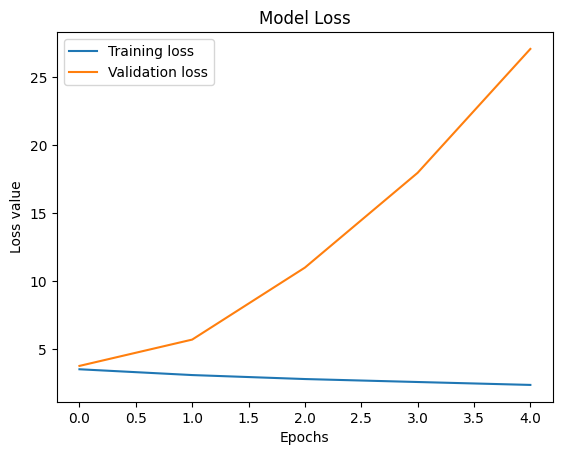

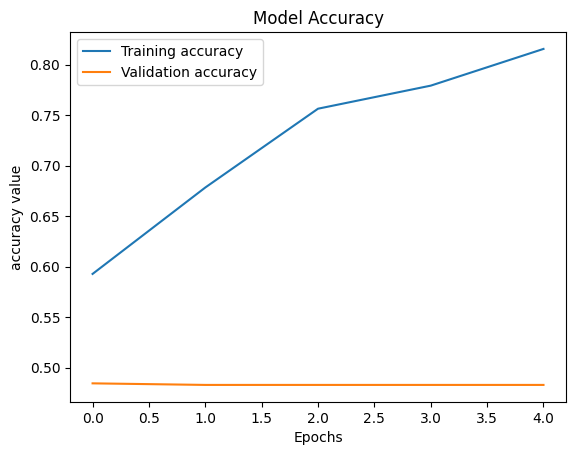

In [36]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Model Loss")
plt.show()


plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy value')
plt.title("Model Accuracy")
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(data_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6962 - loss: 0.9587
Test Loss: 0.9597
Test Accuracy: 0.6731


In [56]:
import pandas as pd
import os
import numpy as np
def create_dataframe_from_directory(directory):
    data = []
    classes = os.listdir(directory)  # List all subdirectories (class labels)
    
    for class_label in classes:
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img)
                # Check if the file path is valid
                if os.path.isfile(img_path):
                    data.append([img_path, class_label])
                else:
                    print("Invalid image filename:", img_path)
    
    return pd.DataFrame(data, columns=['image', 'label'])



training_dir = "C:\\AI_UMAIR\\chest_xray\\train"
valid_dir = "C:\\AI_UMAIR\\chest_xray\\val"
test_dir = "C:\\AI_UMAIR\\chest_xray\\test"

create_dataframe_from_directory(test_dir)

,image,label
0,C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0013-000...,NORMAL
1,C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0015-000...,NORMAL
2,C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0016-000...,NORMAL
3,C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0017-000...,NORMAL
4,C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0019-000...,NORMAL
...,...,...
1282,C:\AI_UMAIR\chest_xray\test\PNEUMONIA\person96...,PNEUMONIA
1283,C:\AI_UMAIR\chest_xray\test\PNEUMONIA\person96...,PNEUMONIA
1284,C:\AI_UMAIR\chest_xray\test\PNEUMONIA\person97...,PNEUMONIA
1285,C:\AI_UMAIR\chest_xray\test\PNEUMONIA\person99...,PNEUMONIA


In [1]:
##Random search
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Define the model creation function
def create_model(learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((3, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (2, 2), activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='selu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define directories
training_dir = "C:\\AI_UMAIR\\chest_xray\\train"
valid_dir = "C:\\AI_UMAIR\\chest_xray\\val"
test_dir = "C:\\AI_UMAIR\\chest_xray\\test"

# Function to create a DataFrame from the directory
def create_dataframe_from_directory(directory):
    data = []
    classes = os.listdir(directory)  # List all subdirectories (class labels)
    
    for class_label in classes:
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img)
                # Check if the file path is valid
                if os.path.isfile(img_path):
                    data.append([img_path, class_label])
                else:
                    print("Invalid image filename:", img_path)
    
    return pd.DataFrame(data, columns=['image', 'label'])

# Create DataFrames for train, validation, and test sets
train_df = create_dataframe_from_directory(training_dir)
valid_df = create_dataframe_from_directory(valid_dir)
test_df = create_dataframe_from_directory(test_dir)

# Check if the DataFrames are not empty
if train_df.empty or valid_df.empty or test_df.empty:
    raise ValueError("One of the DataFrames (train, valid, test) is empty. Check your directories and file paths.")

# Define image data generators
IMG_SHAPE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Use flow_from_dataframe to load images
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')
valid_gen = valid_datagen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')

# Verify the contents of the DataFrame
print(train_df.head())
print(valid_df.head())
print(test_df.head())


# Define the search space
search_space = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Perform Random Search
num_trials = 10
best_val_accuracy = 0
best_hyperparams = {}

for _ in range(num_trials):
    # Randomly sample hyperparameters
    lr = np.random.choice(search_space['learning_rate'])
    dropout_rate = np.random.choice(search_space['dropout_rate'])
    
    # Create and train the model
    model = create_model(learning_rate=lr, dropout_rate=dropout_rate)
    history = model.fit(train_gen, epochs=10, validation_data=valid_gen, verbose=0)
    
    # Evaluate the model
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Trial with learning_rate={lr} and dropout_rate={dropout_rate} has validation accuracy={val_accuracy}")
    
    # Update the best hyperparameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hyperparams = {'learning_rate': lr, 'dropout_rate': dropout_rate}

print(f"Best validation accuracy: {best_val_accuracy} with hyperparameters: {best_hyperparams}")

# Train final model with best hyperparameters
best_model = create_model(learning_rate=best_hyperparams['learning_rate'], dropout_rate=best_hyperparams['dropout_rate'])
best_model.fit(train_gen, epochs=20, validation_data=valid_gen)

# Evaluate the final model on test data
scores = best_model.evaluate(test_gen)
print("Model accuracy with test data:", scores[1] * 100)


Found 4511 validated image filenames belonging to 2 classes.
Found 642 validated image filenames belonging to 2 classes.
Found 1287 validated image filenames belonging to 2 classes.


c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                                               image   label
0      C:\AI_UMAIR\chest_xray\train\NORMAL\.DS_Store  NORMAL
1  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0115-00...  NORMAL
2  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0117-00...  NORMAL
3  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0119-00...  NORMAL
4  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0122-00...  NORMAL
                                               image   label
0        C:\AI_UMAIR\chest_xray\val\NORMAL\.DS_Store  NORMAL
1  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0001-0001...  NORMAL
2  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0003-0001...  NORMAL
3  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0005-0001...  NORMAL
4  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0006-0001...  NORMAL
                                               image   label
0  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0013-000...  NORMAL
1  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0015-000...  NORMAL
2  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0016-000...  NORMAL
3  C:\AI_UMAIR\chest_xra

c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Trial with learning_rate=0.001 and dropout_rate=0.2 has validation accuracy=0.8535825610160828
Trial with learning_rate=0.001 and dropout_rate=0.3 has validation accuracy=0.7242990732192993
Trial with learning_rate=0.0001 and dropout_rate=0.2 has validation accuracy=0.9252336621284485
Trial with learning_rate=0.01 and dropout_rate=0.2 has validation accuracy=0.9314641952514648
Trial with learning_rate=0.01 and dropout_rate=0.4 has validation accuracy=0.9454828500747681
Trial with learning_rate=0.01 and dropout_rate=0.3 has validation accuracy=0.8909657597541809
Trial with learning_rate=0.001 and dropout_rate=0.4 has validation accuracy=0.6542056202888489
Trial with learning_rate=0.01 and dropout_rate=0.3 has validation accuracy=0.4875389337539673
Trial with learning_rate=0.0001 and dropout_rate=0.2 has validation accuracy=0.9610592126846313
Trial with learning_rate=0.0001 and dropout_rate=0.4 has validation accuracy=0.8971962332725525
Best validation accuracy: 0.9610592126846313 with h

In [1]:
#################################################################
#Final Model
################################################################
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define the model creation function
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((3, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Conv2D(128, (3, 3), strides=2, activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (2, 2), activation='relu', padding='same'),
        MaxPool2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='selu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define directories
training_dir = "C:\\AI_UMAIR\\chest_xray\\train"
valid_dir = "C:\\AI_UMAIR\\chest_xray\\val"
test_dir = "C:\\AI_UMAIR\\chest_xray\\test"

# Function to create a DataFrame from the directory
def create_dataframe_from_directory(directory):
    data = []
    classes = os.listdir(directory)  # List all subdirectories (class labels)
    
    for class_label in classes:
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img)
                # Check if the file path is valid
                if os.path.isfile(img_path):
                    data.append([img_path, class_label])
                else:
                    print("Invalid image filename:", img_path)
    
    return pd.DataFrame(data, columns=['image', 'label'])

# Create DataFrames for train, validation, and test sets
train_df = create_dataframe_from_directory(training_dir)
valid_df = create_dataframe_from_directory(valid_dir)
test_df = create_dataframe_from_directory(test_dir)

# Check if the DataFrames are not empty
if train_df.empty or valid_df.empty or test_df.empty:
    raise ValueError("One of the DataFrames (train, valid, test) is empty. Check your directories and file paths.")

# Define image data generators
IMG_SHAPE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Use flow_from_dataframe to load images
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')
valid_gen = valid_datagen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=IMG_SHAPE, batch_size=BATCH_SIZE, class_mode='binary')

# Verify the contents of the DataFrame
print(train_df.head())
print(valid_df.head())
print(test_df.head())

# Create the model
model = create_model()

# Define the checkpoint callback to save the best model
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=[checkpoint_cb])

# Load the best model
model.load_weights("best_model.keras")

# Evaluate the final model on test data
scores = model.evaluate(test_gen)
print("Model accuracy with test data:", scores[1] * 100)

# Save the final model
model.save("final_model.keras")

# Plotting training history


Found 4511 validated image filenames belonging to 2 classes.
Found 642 validated image filenames belonging to 2 classes.
Found 1287 validated image filenames belonging to 2 classes.


c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                                               image   label
0      C:\AI_UMAIR\chest_xray\train\NORMAL\.DS_Store  NORMAL
1  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0115-00...  NORMAL
2  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0117-00...  NORMAL
3  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0119-00...  NORMAL
4  C:\AI_UMAIR\chest_xray\train\NORMAL\IM-0122-00...  NORMAL
                                               image   label
0        C:\AI_UMAIR\chest_xray\val\NORMAL\.DS_Store  NORMAL
1  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0001-0001...  NORMAL
2  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0003-0001...  NORMAL
3  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0005-0001...  NORMAL
4  C:\AI_UMAIR\chest_xray\val\NORMAL\IM-0006-0001...  NORMAL
                                               image   label
0  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0013-000...  NORMAL
1  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0015-000...  NORMAL
2  C:\AI_UMAIR\chest_xray\test\NORMAL\IM-0016-000...  NORMAL
3  C:\AI_UMAIR\chest_xra

c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 93s 629ms/step - accuracy: 0.8484 - loss: 0.3778 - val_accuracy: 0.5171 - val_loss: 1.1505
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 610ms/step - accuracy: 0.9633 - loss: 0.1453 - val_accuracy: 0.5171 - val_loss: 1.9580
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 611ms/step - accuracy: 0.9822 - loss: 0.0619 - val_accuracy: 0.5171 - val_loss: 1.8757
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 612ms/step - accuracy: 0.9877 - loss: 0.0492 - val_accuracy: 0.6199 - val_loss: 1.0057
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 606ms/step - accuracy: 0.9918 - loss: 0.0422 - val_accuracy: 0.7819 - val_loss: 0.6230
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.9891 - loss: 0.0435 - val_accuracy: 0.8956 - val_loss: 0.2997
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 609ms/step - accuracy: 0.9939 - loss: 0.0307 - val_accuracy: 0.9439 - val_loss: 0.1752
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 605ms/step - accuracy: 0.9916 - loss: 0.0277 - val

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [3]:
model.load_weights("best_model.keras")

# Evaluate the final model on test data
scores = model.evaluate(test_gen)
print("Model accuracy with test data:", scores[1] * 100)

# Save the final model
model.save("final_model.keras")

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.8926 - loss: 0.5076
Model accuracy with test data: 89.66588973999023


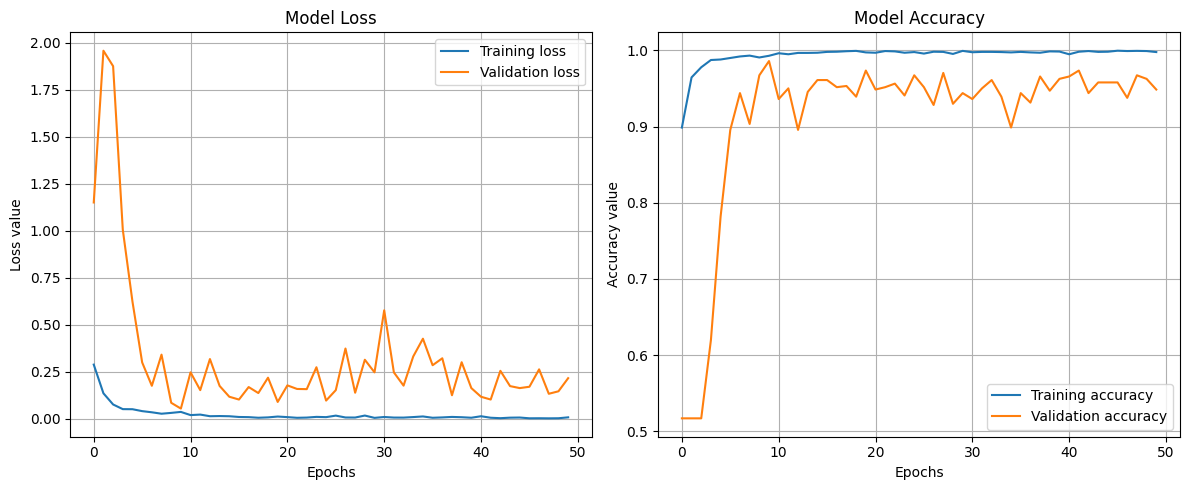

In [2]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Model Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.title("Model Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dir = "C:\\AI_UMAIR\\chest_xray\\test"
image_size = (150, 150)
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # Change to 'categorical' if you have more than 2 classes
    shuffle=False
)
model = tf.keras.models.load_model('final_model.keras')
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Found 1287 images belonging to 2 classes.


c:\Users\AMD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.7608 - loss: 0.9744
Test Loss: 0.4295
Test Accuracy: 0.8967


In [3]:
prediction= model.predict(test_generator)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step


In [4]:
prediction

array([[0.00117249],
       [0.98814857],
       [0.00497848],
       ...,
       [0.9997223 ],
       [0.9988572 ],
       [0.92053145]], dtype=float32)